# Requirements

In [1]:
import keras
import pandas as pd
import seaborn as sns

from transformers import pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense

# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the primary objective is to use Long Short-Term Memory (LSTM) networks for time series forecasting in order to predict the current **close price** of the Dow Jones Industrial Average index. To accomplish this use data from the past 7 days, which includes numeric information and news information. The goal is to employ LSTM, a type of recurrent neural network, to effectively forecast one future step for the index price (the following day).


## The DIJA Dataset

This dataset consists of daily price records for the value of the Dow Jones Industrial Average index. The dataset includes the following attributes:

- Date - date in the format YYYY-MM-DD,
- Open - open price of the index on the specified date
- Close - close price of the index on the specified date
- High - high price of the index on the specified date
- Low - low price of the index on the specified date
- Volume - number of trades



## The Reddit News Dataset

This dataset consists of news headlines for a certain date that might impact the price:

- Date - date in the format YYYY-MM-DD,
- News - news headline scraped from Reddit

<b>Note: You might have multiple headlines for each date. The number of news per date might not be the same for each date. <b>

Load the datasets into a `pandas` data frame.

In [2]:
dija = pd.read_csv("data/DJIA_table.csv")
dija.head()

,Date,Open,High,Low,Close,Volume
0,7/1/2016,17924.24023,18002.38086,17916.91016,17949.36914,82160000
1,6/30/2016,17712.75977,17930.60938,17711.80078,17929.99023,133030000
2,6/29/2016,17456.01953,17704.50977,17456.01953,17694.67969,106380000
3,6/28/2016,17190.50977,17409.72070,17190.50977,17409.72070,112190000
4,6/27/2016,17355.21094,17355.21094,17063.08008,17140.24023,138740000


In [3]:
reddit = pd.read_csv("data/RedditNews.csv")
reddit.head()

,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...


In [4]:
dija['Date'] = pd.to_datetime(dija['Date'])
reddit['Date'] = pd.to_datetime(reddit['Date'])

Merge the datasets (be careful you can get multiple rows per date which is not desirable)

In [5]:
reddit = reddit.groupby('Date')['News'].apply(' '.join).reset_index()

In [6]:
df = pd.merge(dija, reddit, how='inner', on='Date')

In [7]:
df.set_index(keys=["Date"], inplace=True)
df.sort_index(inplace=True)
df.head()

,Open,High,Low,Close,Volume,News
Date,,,,,,
2008-08-08,11432.08984,11759.95996,11388.04004,11734.32031,212830000,"b""Georgia 'downs two Russian warplanes' as cou..."
2008-08-11,11729.66992,11867.11035,11675.53027,11782.34961,183190000,b'Why wont America and Nato help us? If they w...
2008-08-12,11781.70020,11782.34961,11601.51953,11642.46973,173590000,b'Remember that adorable 9-year-old who sang a...
2008-08-13,11632.80957,11633.78027,11453.33984,11532.95996,182550000,b' U.S. refuses Israel weapons to attack Iran:...
2008-08-14,11532.07031,11718.28027,11450.88965,11615.92969,159790000,b'All the experts admit that we should legalis...


## Feauture Extraction


1. DIJA Table
Apply a lag of one, up to 7 days to each feature, creating a set of features representing the index price from the previous 7 days. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

2. Reddit News Table
Create a numeric representation for the news (for example average embedding or average sentiment). <b> You must create lags of the news features as well since we will not know the news for the future. </b>

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [8]:
lags = range(7, 0, -1)
list(lags)

[7, 6, 5, 4, 3, 2, 1]

In [9]:
for lag in lags:
    for column in dija.columns[1:]:
        df[f"{column}_{lag}"] = df[column].shift(lag)
df.dropna(inplace=True)
df.head()

,Open,High,Low,Close,Volume,News,Open_7,High_7,Low_7,Close_7,...,Open_2,High_2,Low_2,Close_2,Volume_2,Open_1,High_1,Low_1,Close_1,Volume_1
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-19,11478.08984,11478.16992,11318.50000,11348.54981,171580000,"b""Man arrested and locked up for five hours af...",11432.08984,11759.95996,11388.04004,11734.32031,...,11611.20996,11709.88965,11599.73047,11659.90039,215040000.0,11659.65039,11690.42969,11434.12012,11479.38965,156290000.0
2008-08-20,11345.94043,11454.15039,11290.58008,11417.42969,144880000,b'Two elderly Chinese women have been sentence...,11729.66992,11867.11035,11675.53027,11782.34961,...,11659.65039,11690.42969,11434.12012,11479.38965,156290000.0,11478.08984,11478.16992,11318.50000,11348.54981,171580000.0
2008-08-21,11415.23047,11476.20996,11315.57031,11430.20996,130020000,"b""British resident held in Guantanamo Bay wins...",11781.70020,11782.34961,11601.51953,11642.46973,...,11478.08984,11478.16992,11318.50000,11348.54981,171580000.0,11345.94043,11454.15039,11290.58008,11417.42969,144880000.0
2008-08-22,11426.79004,11632.12988,11426.79004,11628.05957,138790000,b'Syria says its ready to put a Russian missil...,11632.80957,11633.78027,11453.33984,11532.95996,...,11345.94043,11454.15039,11290.58008,11417.42969,144880000.0,11415.23047,11476.20996,11315.57031,11430.20996,130020000.0
2008-08-25,11626.19043,11626.26953,11362.62988,11386.25000,148610000,"b""N Korea's Kim died in 2003; replaced by look...",11532.07031,11718.28027,11450.88965,11615.92969,...,11415.23047,11476.20996,11315.57031,11430.20996,130020000.0,11426.79004,11632.12988,11426.79004,11628.05957,138790000.0


In [10]:
df.drop(columns=['Open', 'High','Low', 'Volume'], inplace=True)
df.head()

,Close,News,Open_7,High_7,Low_7,Close_7,Volume_7,Open_6,High_6,Low_6,...,Open_2,High_2,Low_2,Close_2,Volume_2,Open_1,High_1,Low_1,Close_1,Volume_1
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-19,11348.54981,"b""Man arrested and locked up for five hours af...",11432.08984,11759.95996,11388.04004,11734.32031,212830000.0,11729.66992,11867.11035,11675.53027,...,11611.20996,11709.88965,11599.73047,11659.90039,215040000.0,11659.65039,11690.42969,11434.12012,11479.38965,156290000.0
2008-08-20,11417.42969,b'Two elderly Chinese women have been sentence...,11729.66992,11867.11035,11675.53027,11782.34961,183190000.0,11781.70020,11782.34961,11601.51953,...,11659.65039,11690.42969,11434.12012,11479.38965,156290000.0,11478.08984,11478.16992,11318.50000,11348.54981,171580000.0
2008-08-21,11430.20996,"b""British resident held in Guantanamo Bay wins...",11781.70020,11782.34961,11601.51953,11642.46973,173590000.0,11632.80957,11633.78027,11453.33984,...,11478.08984,11478.16992,11318.50000,11348.54981,171580000.0,11345.94043,11454.15039,11290.58008,11417.42969,144880000.0
2008-08-22,11628.05957,b'Syria says its ready to put a Russian missil...,11632.80957,11633.78027,11453.33984,11532.95996,182550000.0,11532.07031,11718.28027,11450.88965,...,11345.94043,11454.15039,11290.58008,11417.42969,144880000.0,11415.23047,11476.20996,11315.57031,11430.20996,130020000.0
2008-08-25,11386.25000,"b""N Korea's Kim died in 2003; replaced by look...",11532.07031,11718.28027,11450.88965,11615.92969,159790000.0,11611.20996,11709.88965,11599.73047,...,11415.23047,11476.20996,11315.57031,11430.20996,130020000.0,11426.79004,11632.12988,11426.79004,11628.05957,138790000.0


In [11]:
sentiment_analysis = pipeline("sentiment-analysis", device=0)
results = sentiment_analysis(list(df['News']), truncation=True, max_length=512)
df['Sentiment_News'] = [result['score'] for result in results]

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [12]:
for lag in lags:
    df[f"Sentiment_News_{lag}"] = df['Sentiment_News'].shift(lag)
df.dropna(inplace=True)
df.head()

,Close,News,Open_7,High_7,Low_7,Close_7,Volume_7,Open_6,High_6,Low_6,...,Close_1,Volume_1,Sentiment_News,Sentiment_News_7,Sentiment_News_6,Sentiment_News_5,Sentiment_News_4,Sentiment_News_3,Sentiment_News_2,Sentiment_News_1
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-28,11715.17969,"b""Military help for Georgia is a 'declaration ...",11478.08984,11478.16992,11318.50000,11348.54981,171580000.0,11345.94043,11454.15039,11290.58008,...,11502.50977,120580000.0,0.996921,0.980580,0.998141,0.998392,0.998518,0.997472,0.996061,0.987873
2008-08-29,11543.95996,b'Russian Prime Minister Vladimir Putin has ac...,11345.94043,11454.15039,11290.58008,11417.42969,144880000.0,11415.23047,11476.20996,11315.57031,...,11715.17969,149150000.0,0.994408,0.998141,0.998392,0.998518,0.997472,0.996061,0.987873,0.996921
2008-09-02,11516.91992,"b""A girl filmed Israeli soldiers' brutality. S...",11415.23047,11476.20996,11315.57031,11430.20996,130020000.0,11426.79004,11632.12988,11426.79004,...,11543.95996,166910000.0,0.881824,0.998392,0.998518,0.997472,0.996061,0.987873,0.996921,0.994408
2008-09-03,11532.87988,b'Poland Legalization of Marijuana - two majou...,11426.79004,11632.12988,11426.79004,11628.05957,138790000.0,11626.19043,11626.26953,11362.62988,...,11516.91992,177090000.0,0.998680,0.998518,0.997472,0.996061,0.987873,0.996921,0.994408,0.881824
2008-09-04,11188.23047,b'Security guards beat man at soccer (football...,11626.19043,11626.26953,11362.62988,11386.25000,148610000.0,11383.55957,11436.24023,11340.41016,...,11532.87988,174250000.0,0.988975,0.997472,0.996061,0.987873,0.996921,0.994408,0.881824,0.998680


In [13]:
df.drop(columns=['Sentiment_News', 'News'], inplace=True)
df.head()

,Close,Open_7,High_7,Low_7,Close_7,Volume_7,Open_6,High_6,Low_6,Close_6,...,Low_1,Close_1,Volume_1,Sentiment_News_7,Sentiment_News_6,Sentiment_News_5,Sentiment_News_4,Sentiment_News_3,Sentiment_News_2,Sentiment_News_1
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-28,11715.17969,11478.08984,11478.16992,11318.50000,11348.54981,171580000.0,11345.94043,11454.15039,11290.58008,11417.42969,...,11381.76953,11502.50977,120580000.0,0.980580,0.998141,0.998392,0.998518,0.997472,0.996061,0.987873
2008-08-29,11543.95996,11345.94043,11454.15039,11290.58008,11417.42969,144880000.0,11415.23047,11476.20996,11315.57031,11430.20996,...,11499.79004,11715.17969,149150000.0,0.998141,0.998392,0.998518,0.997472,0.996061,0.987873,0.996921
2008-09-02,11516.91992,11415.23047,11476.20996,11315.57031,11430.20996,130020000.0,11426.79004,11632.12988,11426.79004,11628.05957,...,11543.38965,11543.95996,166910000.0,0.998392,0.998518,0.997472,0.996061,0.987873,0.996921,0.994408
2008-09-03,11532.87988,11426.79004,11632.12988,11426.79004,11628.05957,138790000.0,11626.19043,11626.26953,11362.62988,11386.25000,...,11471.90039,11516.91992,177090000.0,0.998518,0.997472,0.996061,0.987873,0.996921,0.994408,0.881824
2008-09-04,11188.23047,11626.19043,11626.26953,11362.62988,11386.25000,148610000.0,11383.55957,11436.24023,11340.41016,11412.87012,...,11416.53027,11532.87988,174250000.0,0.997472,0.996061,0.987873,0.996921,0.994408,0.881824,0.998680


## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [14]:
X, y = df.drop(columns=['Close']), df['Close']

In [15]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.20, shuffle=False, random_state=0)

## Feauture Scaling
Scale the extracted features using an appropriate scaler if needed.

In [16]:
scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [17]:
scaler = MinMaxScaler()
train_y = scaler.fit_transform(train_y.to_numpy().reshape(-1, 1))

## Feature Reshaping

Reshape the feature dimensions into the shape `(samples, timesteps, features)`.

In [18]:
lag = 7
(train_X.shape[0], lag, (train_X.shape[1] // lag))

(1580, 7, 6)

In [19]:
train_X = train_X.reshape((train_X.shape[0], lag, (train_X.shape[1] // lag)))
test_X = test_X.reshape((test_X.shape[0], lag, (test_X.shape[1] // lag)))

## Long Short-Term Memory (LSTM) Network


Define the forecasting model using the **Keras Sequential API** (`keras.models.Sequential`), incorporating one or more LSTM layers along with additional relevant layers (`keras.layers`). Be cautious when specifying the configuration of the final layer to ensure proper model output for the forecasting task.

In [47]:
model = Sequential([
    Input((train_X.shape[1], train_X.shape[2],)),
    LSTM(64, activation="relu", return_sequences=True),
    LSTM(32, activation="relu"),
    Dense(1, activation="linear")
])

In [48]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 7, 64)               │          18,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,625 (119.63 KB)

 Trainable params: 30,625 (119.63 KB)

 Non-trainable params: 0 (0.00 B)

Compile the previously defined model specifying **loss function** (`keras.losses`), **optimizer** (`keras.optimizers`) and **evaluation metrics** (`keras.metics`).

In [49]:
model.compile(
    loss="mean_squared_error",
    optimizer="adam",
    metrics=["mean_squared_error"],
)

Train the model on the training set, specifying the **batch size** and **number of epochs** for the training process. Allocate 20% of the samples for **validation**, and ensure that the dataset remains **unshuffled** during training.

In [50]:
history = model.fit(train_X, train_y, validation_split=0.20, epochs=35, batch_size=32, shuffle=False)

Epoch 1/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0280 - mean_squared_error: 0.0280 - val_loss: 7.2632e-04 - val_mean_squared_error: 7.2632e-04
Epoch 2/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0233 - mean_squared_error: 0.0233 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 3/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0197 - mean_squared_error: 0.0197 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 4/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0210 - mean_squared_error: 0.0210 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 5/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0249 - mean_squared_error: 0.0249 - val_loss: 8.4828e-04 - val_mean_squared_error: 8.4828e-04
Epoch 6/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0271 - mean_squared_error: 0.0271 - val_loss: 8.8891e-04 - val_mean_squared_error: 8.8891e-04
Epoch 7/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0278 - mean_squared_error: 0.0278 - val

Create a line plot illustrating both the **training** and **validation loss** over the training epochs.

<Axes: >

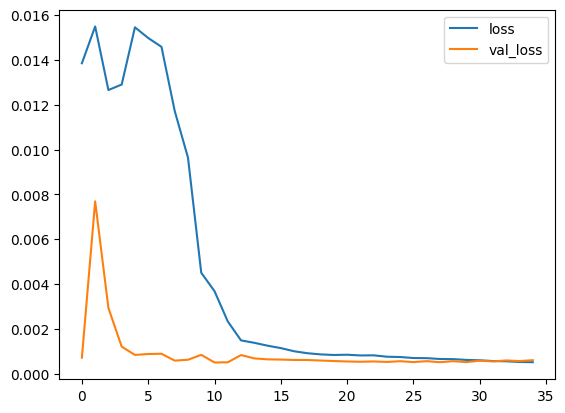

In [51]:
sns.lineplot(history.history["loss"], label="loss")
sns.lineplot(history.history["val_loss"], label="val_loss")

Use the trained model to make predictions for the test set.

In [52]:
pred_y = model.predict(test_X)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [53]:
pred_y = scaler.inverse_transform(pred_y)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [54]:
r2_score(test_y, pred_y)

0.6960390286117186

Create a line plot in order to compare the actual and predicted mean temperatures for the test set.

<Axes: xlabel='Date'>

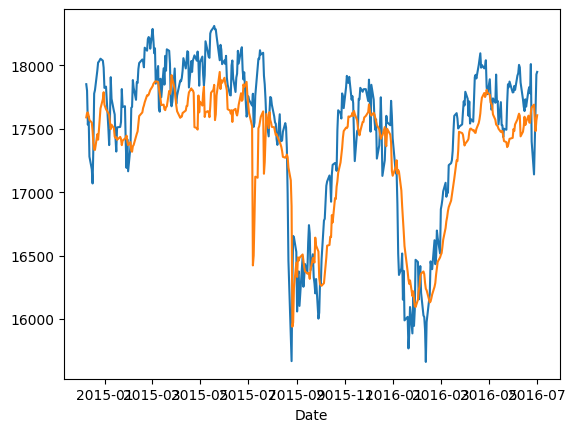

In [55]:
sns.lineplot(x=test_y.index, y=test_y.values)
sns.lineplot(x=test_y.index, y=pred_y.flatten())